In [1]:
import sympy as smp
import matplotlib.pyplot as plt
smp.init_printing(use_latex='mathjax')
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
from xnp import *
backend = 'cupy' if getattr(np, '__name__', '') == 'cupy' else 'numpy'
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

Using NumPy and SciPy on CPU


In [2]:
#Lets find some entropy

In [3]:
rmax = 1000000000
num = 500

In [103]:
#lets do a 4d planar BH
d=2
k=0
#placeholders for other vars
# the issue with these guys is that i have absolutely zero clue what "sensible" values would be for these
l=1
q=0

In [104]:
#lets define some functions?
def mu(R,d=d,k=k,l=l,q=q):
    return (R**(d-2))*(k+(q**2)/(R**(2*d-4))+(R**2)/(l**2))
def f(r,R,l=l,q=q,d=d,k=k):
    return k - mu(R)/(r**(d-2)) + (q**2)/(r**(2*d-4)) + (r**2)/(l**2)

def fp(r,R,l=l,q=q,d=d):
    return (d-2)*mu(R,d,k,l,q)/(r**(d-3)) + (4-2*d)*(q**2)/(r**(2*d-5))+ 2*r/(l**2)

def beta(R):
    return 4 * np.pi / fp(R,R)

def gamma2(r0,R):
    return -1*f(r0,R)*(r0**(2*d-4))

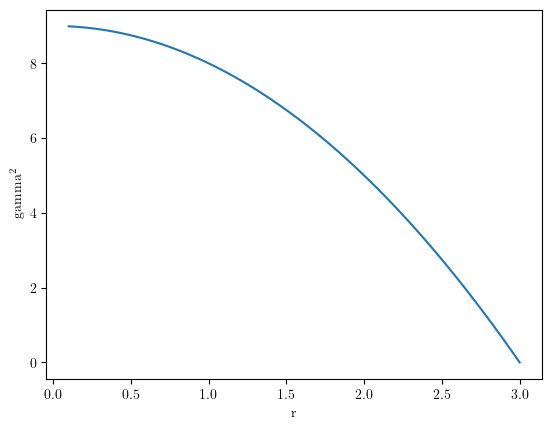

In [105]:
plt.plot(np.linspace(0.1,3,1000),gamma2(np.linspace(0.1,3,1000),3))
plt.ylabel(r'gamma$^2$')
plt.xlabel('r')
plt.show()

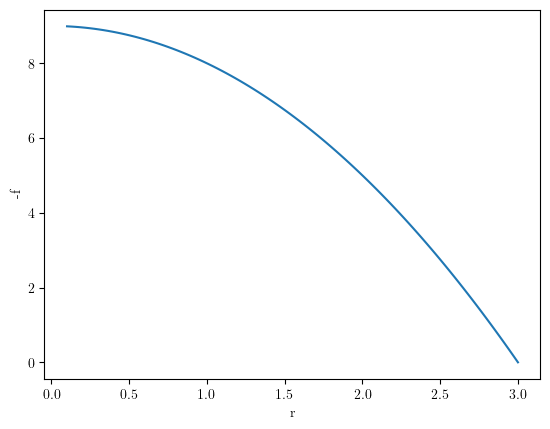

In [106]:
plt.plot(np.linspace(0.1,3,100),-f(np.linspace(0.1,3,100),3))
# plt.semilogy()
plt.ylabel('-f')
plt.xlabel("r")
plt.show()

In [107]:
#lets get a nice correlation between alpha and r0
# tried to keep this all vectorized, but was getting weird outputs and not the right divergences so its time for for loops (yippee!!!)
def k1(r0grid,R):
    list = []
    for i in range(num):
        r0 = r0grid[i]
        rbar = 1#R / 2
        rgrid = np.linspace(rbar,r0,num)
        integ = 1/f(rgrid,R)
        mask = np.isfinite(integ)
        sum =  (4 * np.pi / beta(R)) * np.trapz(integ[mask],rgrid[mask])
        list.append(sum)
    return np.array(list)

def k2(r0grid,R):
    list = []
    for i in range(num):
        r0 = r0grid[i]
        rgrid = np.logspace(np.log10(R+0.001),np.log10(rmax),num)
        integ = (1 - 1/(np.sqrt(1+f(rgrid,R)*(rgrid**(2*d-4))/(gamma2(r0,R)))))/f(rgrid,R)
        mask = np.isfinite(integ)
        sum = (2*np.pi/beta(R)) * np.trapz(integ[mask],rgrid[mask])
        list.append(sum)
    return np.array(list)

def k3(r0grid,R):
    list = []
    for i in range(num):
        r0 = r0grid[i]
        rgrid = np.linspace(r0,R-0.1,num)
        integ = (1 - 1/(np.sqrt(1+f(rgrid,R)*(rgrid**(2*d-4))/(gamma2(r0,R))))/f(rgrid,R))
        mask = np.isfinite(integ)
        sum = (4*np.pi/beta(R)) * np.trapz(integ[mask],rgrid[mask])
        list.append(sum)
    return np.array(list)

In [108]:
# ok debug thoughts
# why is the expression inside the sqrt negative for most of the interior??
# could either take real component or ignore nans like i am now, both feel hacky and not great
# what do i do???

In [109]:
R=3
r0=2
rgrid=np.linspace(r0,R,100)
1+f(rgrid,R)*(rgrid**(2*d-4))/(gamma2(r0,R))

array([0.        , 0.00810121, 0.01624324, 0.02442608, 0.03264973,
       0.04091419, 0.04921947, 0.05756555, 0.06595245, 0.07438017,
       0.08284869, 0.09135802, 0.09990817, 0.10849913, 0.11713091,
       0.12580349, 0.13451689, 0.14327109, 0.15206612, 0.16090195,
       0.16977859, 0.17869605, 0.18765432, 0.1966534 , 0.2056933 ,
       0.214774  , 0.22389552, 0.23305785, 0.24226099, 0.25150495,
       0.26078972, 0.27011529, 0.27948169, 0.28888889, 0.2983369 ,
       0.30782573, 0.31735537, 0.32692582, 0.33653709, 0.34618916,
       0.35588205, 0.36561575, 0.37539027, 0.38520559, 0.39506173,
       0.40495868, 0.41489644, 0.42487501, 0.4348944 , 0.4449546 ,
       0.45505561, 0.46519743, 0.47538006, 0.48560351, 0.49586777,
       0.50617284, 0.51651872, 0.52690542, 0.53733293, 0.54780124,
       0.55831038, 0.56886032, 0.57945108, 0.59008264, 0.60075502,
       0.61146822, 0.62222222, 0.63301704, 0.64385267, 0.65472911,
       0.66564636, 0.67660443, 0.68760331, 0.698643  , 0.70972

In [110]:
def alpha(r0grid,R):
    return 2*np.exp(k1(r0grid,R)+k2(r0grid,R)+k3(r0grid,R))

In [111]:
#lets get an array relating r0 to alpha for fixed R=10
R = 3
r0grid = np.linspace(0.1,R-0.1,num)
alphagrid = alpha(r0grid,R)

k1grid = k1(r0grid,R)


k2grid = k2(r0grid,R)


k3grid = k3(r0grid,R)



# need to convert from CuPy array to NumPy array, something about being on the GPU.. if this breaks on mac just comment it all out lol
# k1grid = k1grid.get()
# k2grid = k2grid.get()
# k3grid = k3grid.get()
# r0grid = r0grid.get()
# alphagrid = alphagrid.get()

/var/folders/sf/wr1kbwcd5dj1bbcsxb86lz7w0000gn/T/ipykernel_72730/4128666108.py:31: RuntimeWarning: divide by zero encountered in divide
  integ = (1 - 1/(np.sqrt(1+f(rgrid,R)*(rgrid**(2*d-4))/(gamma2(r0,R))))/f(rgrid,R))
/var/folders/sf/wr1kbwcd5dj1bbcsxb86lz7w0000gn/T/ipykernel_72730/4128666108.py:31: RuntimeWarning: invalid value encountered in sqrt
  integ = (1 - 1/(np.sqrt(1+f(rgrid,R)*(rgrid**(2*d-4))/(gamma2(r0,R))))/f(rgrid,R))


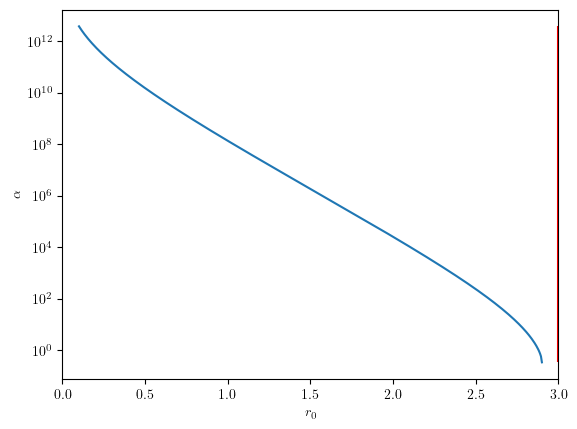

In [112]:
plt.plot(r0grid,alphagrid,label=r'$\alpha$')
plt.xlabel(r'$r_0$')
plt.ylabel(r'$\alpha$')
plt.vlines(R,alphagrid.min(),alphagrid.max(),colors='r',label="Horizon")
plt.semilogy()
plt.xlim((0,3.0))
# plt.ylim((1,10))
plt.show()

In [113]:
#now just have to integrate our area functional from inf to R, from R to r0...
#i guess we can just do this a million billion times, varying alpha -> varying r0
#this will be so fun yippee!!!!

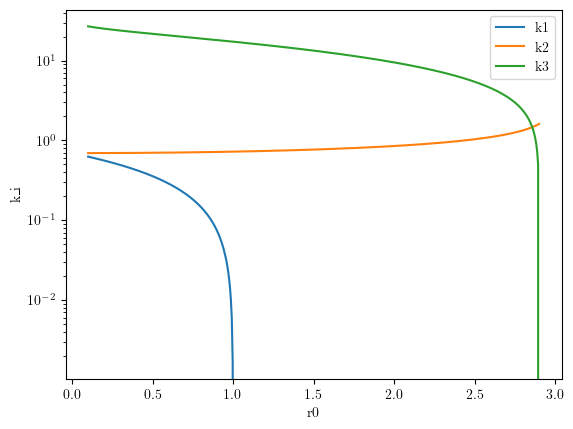

In [114]:
plt.plot(r0grid,k1grid,label='k1')
plt.plot(r0grid,k2grid,label='k2')
plt.plot(r0grid,k3grid,label='k3')
plt.xlabel('r0')
plt.ylabel('k_i')
plt.legend()
# plt.semilogx()
plt.semilogy()
plt.show()

In [115]:
def det(rgrid,R):
    # rough estimate of r_crit in EQ 40 of 1405.7365
    eqgrid = fp(rgrid,R)*rgrid+(2*d-4)*f(rgrid,R)
    print(f'eqgrid: {eqgrid}')
    print(f'abseqgrid: {np.abs(eqgrid)}')
    minloc = np.argmin(np.abs(eqgrid))
    return eqgrid[minloc],rgrid[minloc]

In [116]:
det(np.linspace(0.001,R,1000000),R)

eqgrid: [2.00000000e-06 2.01201400e-06 2.02406398e-06 ... 1.79999280e+01
 1.79999640e+01 1.80000000e+01]
abseqgrid: [2.00000000e-06 2.01201400e-06 2.02406398e-06 ... 1.79999280e+01
 1.79999640e+01 1.80000000e+01]


(2e-06, 0.001)

In [117]:
# ok so like
# divergences are absolutely NOT what the taylor series in paper would suggest (except for k1 and like the rightmost bit of k2)
# k3 should blow up around 1.367 but certainly does not do that
# honestly tho i have no clue what is going on rn
# may f0 and r0 are bad who knows
# what if i need to write my own riemann integral to deal with the imaginary cases, if trapz is integrating over invalid spaces still then we could have issues / overestimates

In [89]:
# well if theres nothing i can do about that rn then i guess i should build the area integral huh
# for now we can just do it with varying r0, and then once the alpha function decides to behave we can modify a touch

In [90]:
# equation 44 of the paper
def areaInteg(rgrid,r0,R):
    return (rgrid**(d-2)) / np.sqrt(f(rgrid,R) + gamma2(r0,R)*(rgrid**(4-2*d)))

In [91]:
# if we let rdot blow up we get this first order term, math was done on my whiteboard once...
def divArea(rgrid,R):
    return (rgrid**(d-2)) / np.sqrt(f(rgrid,R))

In [ ]:
def area(r0grid,R):
    areaList = []
    area1List = []
    area2List = []
    rgrid1 = np.logspace(np.log10(R+0.1),np.log10(rmax),num)
    divAreaInteg = divArea(rgrid1,R)
    for i in range(num):
        r0 = r0grid[i]
        rgrid2 = np.linspace(r0,R-0.1,num)
        areaInteg1 = areaInteg(rgrid1,r0,R) - divAreaInteg
        area1 = np.trapz(areaInteg1,rgrid1)
        areaInteg2 = areaInteg(rgrid2,r0,R)
        mask = np.isfinite(areaInteg2)
        area2 = np.trapz(areaInteg2[mask],rgrid2[mask])
        areaSum = (2 * area1) + (4 * area2)
        areaList.append(areaSum)
        area1List.append(area1)
        area2List.append(area2)
    return np.array(areaList) # , area1List, area2List

In [93]:
rgrid2 = np.linspace(1,R-0.1,num)

/var/folders/sf/wr1kbwcd5dj1bbcsxb86lz7w0000gn/T/ipykernel_72730/1978728994.py:5: RuntimeWarning: divide by zero encountered in divide
  return k - mu(R)/(r**(d-2)) + (q**2)/(r**(2*d-4)) + (r**2)/(l**2)
/var/folders/sf/wr1kbwcd5dj1bbcsxb86lz7w0000gn/T/ipykernel_72730/1978728994.py:5: RuntimeWarning: invalid value encountered in divide
  return k - mu(R)/(r**(d-2)) + (q**2)/(r**(2*d-4)) + (r**2)/(l**2)


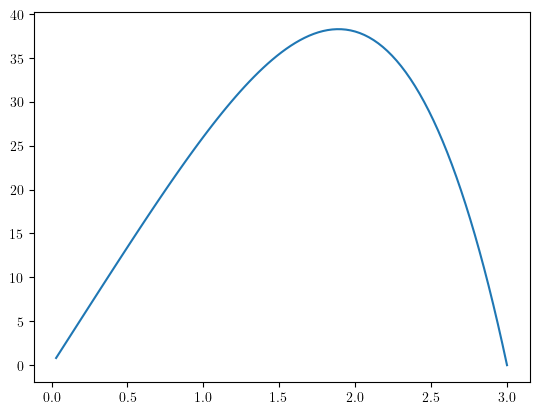

In [94]:
plt.plot(np.linspace(0,3,100),gamma2(np.linspace(0,3,100),3))

In [95]:
areaInteg2 = areaInteg(rgrid2,2,R)
areaInteg2

/var/folders/sf/wr1kbwcd5dj1bbcsxb86lz7w0000gn/T/ipykernel_72730/559195508.py:3: RuntimeWarning: invalid value encountered in sqrt
  return (rgrid**(d-2)) / np.sqrt(f(rgrid,R) + gamma2(r0,R)*(rgrid**(4-2*d)))


array([ 0.28867513,  0.29194383,  0.29524681,  0.29858452,  0.30195743,
        0.30536598,  0.30881065,  0.31229191,  0.31581026,  0.31936619,
        0.3229602 ,  0.32659281,  0.33026455,  0.33397594,  0.33772754,
        0.34151989,  0.34535357,  0.34922915,  0.35314721,  0.35710837,
        0.36111322,  0.36516239,  0.36925652,  0.37339626,  0.37758226,
        0.3818152 ,  0.38609577,  0.39042467,  0.39480261,  0.39923033,
        0.40370858,  0.4082381 ,  0.4128197 ,  0.41745414,  0.42214226,
        0.42688486,  0.43168281,  0.43653695,  0.44144819,  0.4464174 ,
        0.45144553,  0.4565335 ,  0.46168228,  0.46689285,  0.47216622,
        0.47750342,  0.48290549,  0.48837351,  0.49390858,  0.49951183,
        0.5051844 ,  0.51092748,  0.51674226,  0.52262998,  0.5285919 ,
        0.53462932,  0.54074356,  0.54693597,  0.55320795,  0.55956091,
        0.56599631,  0.57251566,  0.57912047,  0.58581232,  0.59259281,
        0.5994636 ,  0.60642638,  0.61348289,  0.6206349 ,  0.62

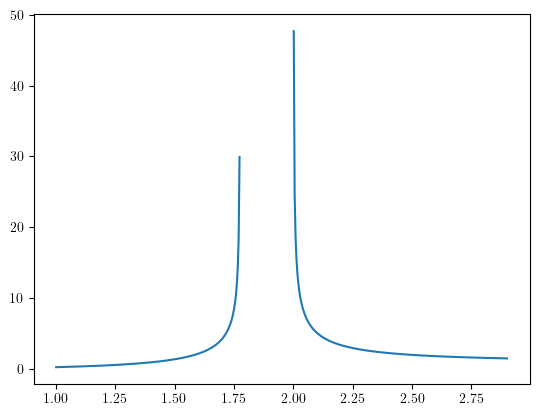

In [96]:
plt.plot(rgrid2,areaInteg2)

In [97]:
testArea, test1, test2 = area(r0grid,R)
testArea

/var/folders/sf/wr1kbwcd5dj1bbcsxb86lz7w0000gn/T/ipykernel_72730/559195508.py:3: RuntimeWarning: invalid value encountered in sqrt
  return (rgrid**(d-2)) / np.sqrt(f(rgrid,R) + gamma2(r0,R)*(rgrid**(4-2*d)))
/var/folders/sf/wr1kbwcd5dj1bbcsxb86lz7w0000gn/T/ipykernel_72730/559195508.py:3: RuntimeWarning: divide by zero encountered in divide
  return (rgrid**(d-2)) / np.sqrt(f(rgrid,R) + gamma2(r0,R)*(rgrid**(4-2*d)))


array([-1.51914286e-01, -1.59608527e-01, -1.67229683e-01, -1.74779545e-01,
       -1.82259829e-01, -1.89672185e-01, -1.97018197e-01, -2.04299386e-01,
       -2.11517217e-01, -2.18673098e-01, -2.25768383e-01, -2.32804378e-01,
       -2.39782341e-01, -2.46703483e-01, -2.53568973e-01, -2.60379938e-01,
       -2.67137467e-01, -2.73842611e-01, -2.80496383e-01, -2.87099765e-01,
       -2.93653705e-01, -3.00159118e-01, -3.06616892e-01, -3.13027885e-01,
       -3.19392927e-01, -3.25712822e-01, -3.31988349e-01, -3.38220263e-01,
       -3.44409296e-01, -3.50556156e-01, -3.56661532e-01, -3.62726090e-01,
       -3.68750478e-01, -3.74735324e-01, -3.80681239e-01,  1.17139248e-01,
       -8.54957168e-02, -1.50444814e-01,  1.56039762e-01,  4.62453516e-02,
        3.88210451e-01,  1.41455443e+07,  6.57053791e-01,  3.84715165e-01,
        1.47104476e+07,  5.39067017e-01,  4.11220891e-01,  6.88413176e-01,
        5.32927486e-01,  8.35796544e-01,  6.46389458e-01,  9.84455292e-01,
        7.51964290e-01,  

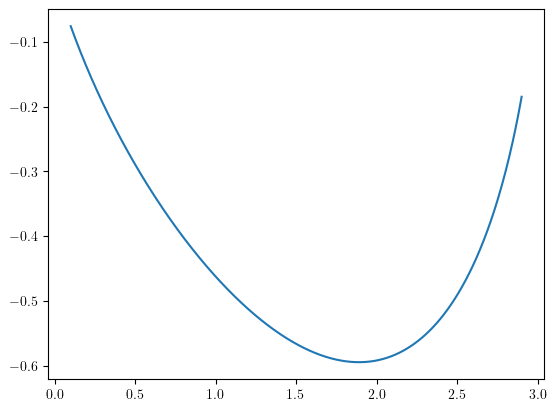

In [98]:
plt.plot(r0grid,test1)

[]

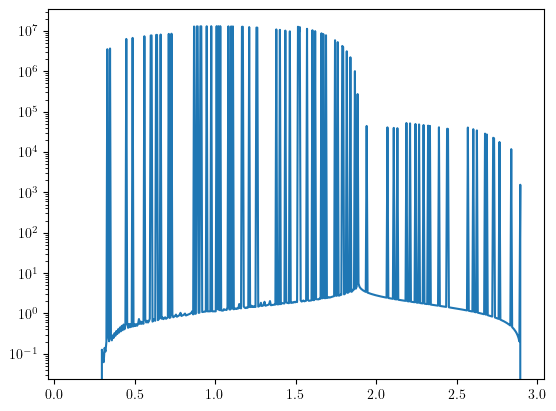

In [99]:
plt.plot(r0grid,test2)
plt.semilogy()

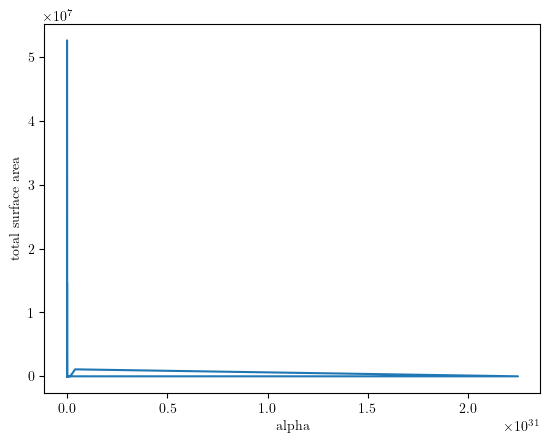

In [100]:
plt.plot(alphagrid,testArea)
plt.xlabel('alpha')
plt.ylabel('total surface area')
# plt.semilogy()
plt.show()